# TRACES - Run deterministic model with "synaptic noise" 

ie artificially create trial-to-trial variability by sampling from Normal distribution the synaptic conductance at each trial

In [1]:
import custommodel as ctm
import deterministicfunc as dgi 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

# Select model to run

In [2]:
# List of possible models to tests: 
# control, increased input resistance, etc
list_models= ['ctr','fdE0','ctrE0','fd']

In [3]:
# ---- CHANNELS

# Main name for channels model to load

chanfile = 'carter_subtchan'

# Action potential detection threshold
APthreshold = -20

# Ion conductance
iong = {'na':35, 'kdr':4, 'subchan':0.18} # mS/cm2 


# ---- INPUT

# Number of loops per synaptic input step
numloops = 20 

prheo = 0.9
prheo_det = 0.9 # this is for the basic "deterministic run"

syn_noise_sd = 4.5 # Ginput
#syn_noise_sd = 0.1 # Iinput


### Groups and parameters for the synaptic input

In [4]:
gl_drop = 0.79

modeldata = {'ctr':{'key_group':'ctr', 'gldrop': 1, 'clamprest': None}, 
             'fd':{'key_group':'fd', 'gldrop': gl_drop, 'clamprest': None}, 
             'fdE0':{'key_group':'ctr', 'gldrop': gl_drop, 'clamprest': None},
             'ctrE0':{'key_group':'fd', 'gldrop': 1, 'clamprest': None}}


### Setup stimulus

In [5]:
stimdelay = 0
stimduration = 325 
intype = 'gsyn' # options: gsyn = conductance ; isyn = current synaptic input 

synparams = {'tau_rise':70, 'tau_decay':75,'Er':0, 'stimdelay':stimdelay, 'delay':0}
# note: 'delay' is an additional delay - see where insert synapse

stim_params = ctm.get_simginputparameters(stimdelay, stimduration, intype, synparams=synparams)

# Select a model to run

In [6]:
model = 'ctr'
#model = 'fdE0'
#model = 'ctrE0'
#model = 'fd'

# Get rheo

In [7]:
isstochastic = False

if intype=='gsyn':
    precision = 1e-3
    offInput = 10
    onInput = 150
else:
    precision = 1e-6
    offInput = 0.1
    onInput = 10

    
print("*** "+model+" ***")

# Get first spike

model_params = ctm.ModelParameters(modeldata[model]['key_group'], isstochastic, 
                                   modeldata[model]['gldrop'], APthreshold, 
                                   chanfile=chanfile, iong=iong,  
                                   clamprest=modeldata[model]['clamprest'])


dgi.check_setup_model_sim(model_params, stim_params)

gfirstspike, _, is_success = dgi.get_firstspike_ginput(model_params,
                                                       stim_params,
                                                       offInput,
                                                       onInput,
                                                       precision)

print(is_success)
print(gfirstspike)



*** ctr ***
------------------------
Display model check...
	-Channels file: ch_carter_subtchan.ses
	-Resting potential and init E0 -75.0000 mV
	-Leak reversal potential -75.0000 mV
	-Leak conductance 0.1000 mS/cm2
	-Capa 1.0000 uF/cm2
	-AP threshold -20.0000 mV
	-Total duration of stimulation 325.00 ms
	-Total duration of simulation 325.00 ms
	-Syn noise for trial variability 0.000 (sd)
True
54.425599999999996


# Run traces

In [8]:
doparallel = False
#doparallel = True
#MAX_WORKERS = None # can leave like that if not doing multiproc
#MAX_WORKERS = os.cpu_count() # to use all ressources
MAX_WORKERS = 0 # select max number 


# Store traces for various simulations with "syn noise"
sto_trace_var_models = {}
# We also run a deterministic trace to get the "average"
det_trace_var_models = {} 



# -- Get deterministic trace
trace_var = dgi.run_ginput_trace(model_params, stim_params, prheo_det * gfirstspike)
det_trace_var_models[model] = {'t':trace_var['t'], 'v':trace_var['v']}


# -- Run "stochastic" trace

# Add "syn noise"
stim_params_synnoise = stim_params.copy()
stim_params_synnoise['syn_noise_sd'] = syn_noise_sd

# Norm noise to control so that we can simply * by amplitude to scale the noise
# (see 'model_setup.py')
stim_params_synnoise['syn_noise_sd'] /= gfirstspike


dgi.check_setup_model_sim(model_params, stim_params_synnoise)



sto_trace_var_models[model] = {'t':[], 'v':[], 'apc':[], 'syn_ge':[]}

for kloop in range(numloops):
    
    trace_var = dgi.run_ginput_trace(model_params, stim_params_synnoise, prheo*gfirstspike, output_g=True)


    sto_trace_var_models[model]['syn_ge'].append(trace_var['syn_ge'][0])
    sto_trace_var_models[model]['v'].append(trace_var['v'][0])
    sto_trace_var_models[model]['apc'].append(trace_var['apc'][0])
    
sto_trace_var_models[model]['t'] = trace_var['t'].copy()

# TODO: delete temporary variable "trace_var" or create function

------------------------
Display model check...
	-Channels file: ch_carter_subtchan.ses
	-Resting potential and init E0 -75.0000 mV
	-Leak reversal potential -75.0000 mV
	-Leak conductance 0.1000 mS/cm2
	-Capa 1.0000 uF/cm2
	-AP threshold -20.0000 mV
	-Total duration of stimulation 325.00 ms
	-Total duration of simulation 325.00 ms
	-Syn noise for trial variability 0.083 (sd)


# Plot

In [9]:
model_params.gl

0.1

In [10]:
palette = {'ctr':(0.4,0.4,0.4), 
           'fd': (0.2,0.2,1),
           'fdE0': (0.9,0,0.3), 
           'ctrE0': (0,0.7,0.35)}    

### Plot basic deterministic and "stochastic"

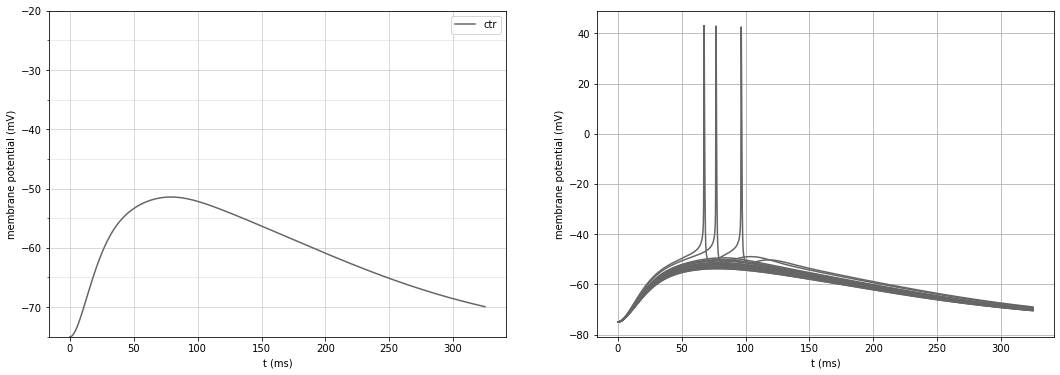

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


# -----------------------------------------------------

idx = 0

ylim = [-75, -20]

major_ticks=-np.arange(0,80,10)
minor_ticks=-np.arange(0,80,5)
   
ax[idx].plot(det_trace_var_models[model]['t'], det_trace_var_models[model]['v'][0],
             color=palette[model], label=model)
ax[idx].set_xlabel('t (ms)')
ax[idx].set_ylabel('membrane potential (mV)')
    
ax[idx].set_yticks(major_ticks)
ax[idx].set_yticks(minor_ticks,minor=True)

ax[idx].grid(which="major",alpha=0.6)
ax[idx].grid(which="minor",alpha=0.3)
    
#ax[idx].grid()
ax[idx].legend()
if ylim:
    ax[idx].set_ylim(ylim)

    
# -----------------------------------------------------

idx = 1

ylim = [-75, -20]
ylim = None

major_ticks=-np.arange(0,80,10)
minor_ticks=-np.arange(0,80,5)

for k in range(numloops):
    ax[idx].plot(sto_trace_var_models[model]['t'], sto_trace_var_models[model]['v'][k],
                 color=palette[model])
ax[idx].set_xlabel('t (ms)')
ax[idx].set_ylabel('membrane potential (mV)')
"""    
ax[idx].set_yticks(major_ticks)
ax[idx].set_yticks(minor_ticks,minor=True)

ax[idx].grid(which="major",alpha=0.6)
ax[idx].grid(which="minor",alpha=0.3)
    """
ax[idx].grid()
if ylim:
    ax[idx].set_ylim(ylim)


### Plot runs with/without AP

In [12]:
sum([apc>0 for apc in sto_trace_var_models[model]['apc']])/numloops

0.1

2


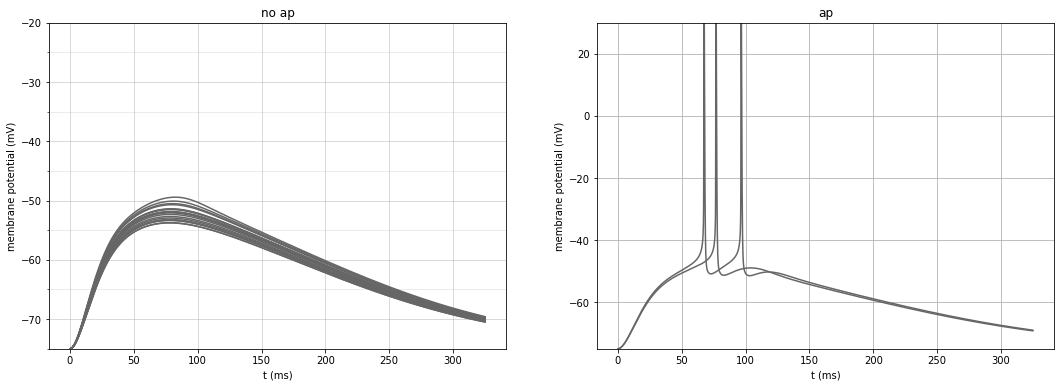

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

idx = 0

ylim = [-75, -20]

major_ticks=-np.arange(0,80,10)
minor_ticks=-np.arange(0,80,5)

for k in range(numloops):
    if sto_trace_var_models[model]['apc'][k]==0:
        ax[idx].plot(sto_trace_var_models[model]['t'], sto_trace_var_models[model]['v'][k],
                     color=palette[model])
ax[idx].set_xlabel('t (ms)')
ax[idx].set_ylabel('membrane potential (mV)')
ax[idx].set_title('no ap')
    
ax[idx].set_yticks(major_ticks)
ax[idx].set_yticks(minor_ticks,minor=True)

ax[idx].grid(which="major",alpha=0.6)
ax[idx].grid(which="minor",alpha=0.3)
    
#ax[idx].grid()
if ylim:
    ax[idx].set_ylim(ylim)

idx = 1
counter = 0
for k in range(numloops):
    if sto_trace_var_models[model]['apc'][k]>0:
        counter+=1
        ax[idx].plot(sto_trace_var_models[model]['t'], sto_trace_var_models[model]['v'][k],
                     color=palette[model])
ax[idx].set_xlabel('t (ms)')
ax[idx].set_ylabel('membrane potential (mV)')
ax[idx].set_title('ap')
    
ax[idx].grid()
ax[idx].set_ylim([-75,30])

print(counter)


### Plot input conductance

Text(0, 0.5, 'input conductance')

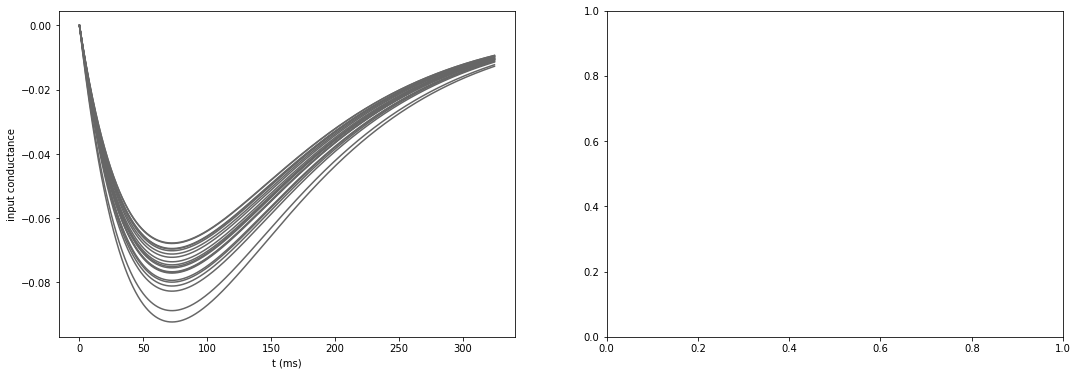

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

idx = 0

for k in range(numloops):
    ax[idx].plot(sto_trace_var_models[model]['t'], 
                 [-g for g in sto_trace_var_models[model]['syn_ge'][k]],
                 color=palette[model])
    
    
ax[idx].set_xlabel('t (ms)')
ax[idx].set_ylabel('input conductance') 